<a href="https://colab.research.google.com/github/teamgaon/lg_farm/blob/main/20220127_hj_EDAipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

본 코드는 SEO_DJ님의 코드를 
참고하였습니다

-------

모든 질병과 CSV 데이터와의 관계를 파악하는 EDA입니다.  
(외부 누적일사 평균 데이터는 제외하였습니다.)

1. 온도/습도/이슬점과 질병 초기/중기/말기간의 상관관계

2. 같은 질병을 가진 다른 작물들이 서로 어떤 분포를 보이는가?
- 흰가루병
- 탄저병
- 다량원소결핍

3. 질병의 초기,중기,말기는 어떤 분포를 보이는가?
- 칼슘결핍
- 일소피해

[생략]
- 노균병(중기밖에 없음)
- 열과(데이터 없음)
- 냉해피해(데이터 없음)
- 축과병(초기 데이터밖에 없음)

## 사용 패키지

In [1]:
# 그래프 한글 폰트 적용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
fc-cache: invalid option -- ']'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths for scanning
  -v, --verbose            display status information while busy
  -V, --version            display font config version and exit
  -h, --help               di

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import json
import time
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/LG/train.zip

## 데이터 살펴보기

In [5]:
sample = glob('/content/train/*')[42]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

In [6]:
start_time = time.time()
tr_json_list = glob('/content/train/*/*.json')
# tr_json_list = ['./data' + x[1:] for x in tr_json_list]
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.14893436431884766 seconds ---


In [13]:
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,내부 온도 4 평균,내부 온도 4 최고,내부 온도 4 최저,내부 습도 1 평균,내부 습도 1 최고,내부 습도 1 최저,내부 습도 2 평균,내부 습도 2 최고,내부 습도 2 최저,내부 습도 3 평균,내부 습도 3 최고,내부 습도 3 최저,내부 습도 4 평균,내부 습도 4 최고,내부 습도 4 최저,내부 이슬점 평균,내부 이슬점 최고,내부 이슬점 최저,내부 CO2 평균,내부 CO2 최고,내부 CO2 최저,외부 풍속 평균,외부 풍속 최고,외부 풍속 최저,내부 EC 1 평균,내부 EC 1 최고,내부 EC 1 최저,내부 PH 1 평균,내부 PH 1 최고,내부 PH 1 최저,배지 중량 평균,배지 중량 최고,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-08-13 15:10:00,28.0,28.1,27.9,-,-,-,-,-,-,-,-,-,79.0,80.0,77.0,-,-,-,-,-,-,-,-,-,24.0,24.2,23.6,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,91.1,-,-
1,2021-08-13 15:00:00,28.2,28.3,28.1,-,-,-,-,-,-,-,-,-,77.8,78.7,77.2,-,-,-,-,-,-,-,-,-,23.8,24.0,23.6,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,97.5,-,-
2,2021-08-13 14:50:00,28.5,28.7,28.4,-,-,-,-,-,-,-,-,-,76.9,78.5,75.6,-,-,-,-,-,-,-,-,-,24.2,24.6,23.4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,100.8,-,-
3,2021-08-13 14:40:00,28.9,29.0,28.7,-,-,-,-,-,-,-,-,-,76.4,77.8,75.8,-,-,-,-,-,-,-,-,-,24.4,24.8,24.3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,109.5,-,-
4,2021-08-13 14:30:00,29.1,29.2,29.0,-,-,-,-,-,-,-,-,-,75.6,77.0,74.3,-,-,-,-,-,-,-,-,-,24.2,24.3,24.1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,134.8,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2021-08-11 15:00:00,31.8,31.9,31.7,-,-,-,-,-,-,-,-,-,69.3,71.9,67.1,-,-,-,-,-,-,-,-,-,25.7,26.3,25.3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,468.2,-,-
290,2021-08-11 14:50:00,31.1,31.2,31.0,-,-,-,-,-,-,-,-,-,69.6,71.1,67.6,-,-,-,-,-,-,-,-,-,24.8,25.1,24.4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,500.1,-,-
291,2021-08-11 14:40:00,31.3,31.3,31.1,-,-,-,-,-,-,-,-,-,71.5,73.0,69.6,-,-,-,-,-,-,-,-,-,25.2,25.6,24.6,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,263.1,-,-
292,2021-08-11 14:30:00,31.7,32.0,31.4,-,-,-,-,-,-,-,-,-,70.7,71.8,69.6,-,-,-,-,-,-,-,-,-,26.0,26.3,25.1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,56.3,-,-


train 데이터를 이용해 EDA를 하기 위해 json 파일을 이용해 DataFrame을 만듭니다.  
변수명을 한글로 바꿔줬습니다.  

(*SEO_DJ님 코드 참조*)

In [7]:
for i, json_file in enumerate(tqdm(tr_json_list)):
    with open(json_file, 'r') as f:
        json_file = json.load(f)
    json_file_re = {
      '주목객체': json_file['annotations']['bbox'],
      '병해부위': json_file['annotations']['part'],
      '촬영부위': json_file['annotations']['area'], 
      '작물': json_file['annotations']['crop'],
      '질병명': json_file['annotations']['disease'],
      '생육단계': json_file['annotations']['grow'],
      '피해정도': json_file['annotations']['risk'],
      '이미지id': json_file['description']['image'],
      '촬영날짜': json_file['description']['date'],
      '촬영시간': json_file['description']['time'],
      'height': json_file['description']['height'],
      'width': json_file['description']['width'],
      '촬영지역': json_file['description']['region'],
      '데이터종류': json_file['description']['task']
      }
    if i == 0:
        tr_json_df = pd.json_normalize(json_file_re)
    else:
        tr_json_df = tr_json_df.append(pd.json_normalize(json_file_re))
tr_json_df = tr_json_df.reset_index(drop=True)

100%|██████████| 5767/5767 [00:44<00:00, 130.14it/s]


In [8]:
# crop
crop_dict = {1 : '딸기',
             2 : '토마토',
             3 : '파프리카',
             4 : '오이', 
             5 : '고추',
             6 : '시설포도'
            }    
# risk
risk_dict = {0 : '정상',
             1 : '초기',
             2 : '중기',
             3 : '말기'}

task_dict = {0 : '정상',
             1 : '병해',
             2 : '생리장해',
            }## 보호제 처리 반응 삭제 tr_json_df['데이터종류'].unique() 3없음
# disease
disease_dict = {'0' : '정상',
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

area_dict = {1 : '열매',
             2 : '꽃',
             3 : '잎',
             4 : '가지',
             5 : '줄기',
             6 : '뿌리',
             7 : '해충'}

grow_dict = {11: '유모기',
             12: '생장기',
             13: '착화/과실기',
             21: '발아기',
             22: '개화기',
             23: '신초생장기',
             24: '과실성숙기',
             25: '수확기',
             26: '휴먼기'}

In [9]:
tr_json_df['label_code'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)
print("train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}")

tr_json_df['작물'] = tr_json_df['작물'].map(crop_dict) + '(' + tr_json_df['작물'].astype(str) + ')'
tr_json_df['질병명'] = tr_json_df['질병명'].map(disease_dict) + '(' + tr_json_df['질병명'].astype(str) + ')'
tr_json_df['피해정도'] = tr_json_df['피해정도'].map(risk_dict) + '(' + tr_json_df['피해정도'].astype(str) + ')'
tr_json_df['데이터종류'] = tr_json_df['데이터종류'].map(task_dict) + '(' + tr_json_df['데이터종류'].astype(str) + ')'
tr_json_df['촬영부위'] = tr_json_df['촬영부위'].map(area_dict) + '(' + tr_json_df['촬영부위'].astype(str) + ')'
tr_json_df['생육단계'] = tr_json_df['생육단계'].map(grow_dict) + '(' + tr_json_df['생육단계'].astype(str) + ')'

tr_json_df['label_name'] =  tr_json_df['작물'].astype(str) + '_'  + tr_json_df['질병명'] + '_' + tr_json_df['피해정도'].astype(str)

train data에 존재하는 class 수: {len(tr_json_df['label_code'].nunique())}


# EDA

### 1. 온도/습도/이슬점과 피해정도 초기/중기/말기간의 상관관계

초기/중기/말기 각각 데이터 프레임을 불러옵니다.

In [14]:
display(tr_json_df[tr_json_df["피해정도"]=="초기(1)"].head())
display(tr_json_df[tr_json_df["피해정도"]=="중기(2)"].head())
display(tr_json_df[tr_json_df["피해정도"]=="말기(3)"].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
3,"[{'x': 121.20540364583333, 'h': 302.6819506448...","[{'x': 234.5145244295635, 'h': 20.022972470238...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),초기(1),32522.jpg,20210622,1414,512,384,0,병해(1),3_a9_1,파프리카(3)_파프리카흰가루병(a9)_초기(1)
5,"[{'x': 69.8591812375992, 'h': 389.052362351190...","[{'x': 135.4280753968254, 'h': 27.428819444444...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),50788.jpg,20210902,1442,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
6,"[{'x': 106.47309802827381, 'h': 370.9862971230...","[{'x': 110.49100167410714, 'h': 360.2718874007...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),20990.jpg,20211109,1205,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)
10,"[{'x': 89.57142857142857, 'h': 402.42860243055...","[{'x': 93.42857142857143, 'h': 393.42860243055...",잎(3),고추(5),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),51832.jpg,20211102,1138,512,384,0,생리장해(2),5_b6_1,고추(5)_다량원소결핍 (N)(b6)_초기(1)
24,"[{'x': 61.98335580977182, 'h': 377.6640625, 'y...","[{'x': 64.82032412574405, 'h': 124.82333519345...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),62718.jpg,20211101,1229,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)


,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
8,"[{'x': 246.2476222826087, 'h': 402.28571428571...","[{'x': 307.1999870600414, 'h': 97.523809523809...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),58122.jpg,20210809,1707,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
19,"[{'x': 0.0, 'h': 375.48694816468253, 'y': 91.8...","[{'x': 189.6039031498016, 'h': 16.900700644841...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),중기(2),32166.jpg,20210622,1525,512,242,0,병해(1),3_a9_2,파프리카(3)_파프리카흰가루병(a9)_중기(2)
21,"[{'x': 82.05714440724206, 'h': 113.14285714285...","[{'x': 175.08572048611111, 'h': 20.80000620039...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),44118.jpg,20211017,1253,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
25,"[{'x': 284.0369130291005, 'h': 160.91761739417...","[{'x': 327.9235284391534, 'h': 37.791253306878...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),12185.jpg,20211017,1240,512,682,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
28,"[{'x': 56.186279296875, 'h': 238.7951388888888...","[{'x': 134.7275390625, 'h': 15.981987847222221...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),중기(2),29854.jpg,20210629,1017,512,242,0,병해(1),3_a9_2,파프리카(3)_파프리카흰가루병(a9)_중기(2)


,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
159,"[{'x': 41.51547386532738, 'h': 423.89298115079...","[{'x': 47.54239133804563, 'h': 354.24863591269...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),33478.jpg,20210706,1030,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)
216,"[{'x': 42.687375992063494, 'h': 451.1815476190...","[{'x': 172.50054253472223, 'h': 160.1810205853...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),12982.jpg,20210622,1434,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)
388,"[{'x': 67.8016338045635, 'h': 339.845238095238...","[{'x': 71.14986359126983, 'h': 330.63758680555...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),35833.jpg,20210622,1434,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)
402,"[{'x': 94.72299895141559, 'h': 469.32112897588...","[{'x': 356.32608790632645, 'h': 124.2832051730...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),30889.jpg,20210807,0655,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
466,"[{'x': 80.74570622519842, 'h': 455.39840649801...","[{'x': 255.43697296626985, 'h': 30.82138206845...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),말기(3),46627.jpg,20210706,0937,512,384,0,병해(1),3_a9_3,파프리카(3)_파프리카흰가루병(a9)_말기(3)


[내부 온도와 초기/중기/말기의 분포]

In [15]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저']

b7 = pd.read_csv('/content/train/63805/63805.csv')[csv_features] #고추
b3 = pd.read_csv('/content/train/18978/18978.csv')[csv_features] #파프리카
b5 =  pd.read_csv('/content/train/18408/18408.csv')[csv_features] #시설포도

a9 =  pd.read_csv('/content/train/31161/31161.csv')[csv_features] #파프리카
a7 =  pd.read_csv('/content/train/53289/53289.csv')[csv_features] #고추
a5 =  pd.read_csv('/content/train/60102/60102.csv')[csv_features] #토마토

a9_1 =  pd.read_csv('/content/train/23323/23323.csv')[csv_features] #파프리카
b4 =  pd.read_csv('/content/train/54869/54869.csv')[csv_features] #시설포도

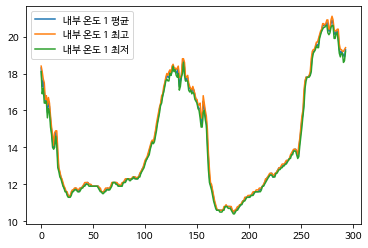

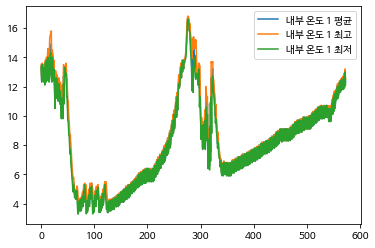

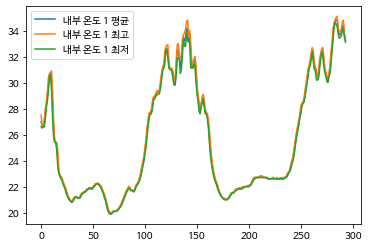

In [16]:
# 초기
b7.plot()
b3.plot()
b5.plot()

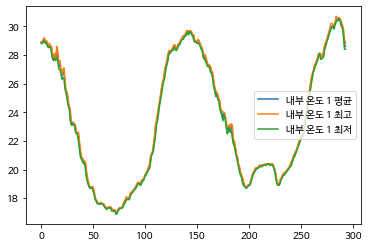

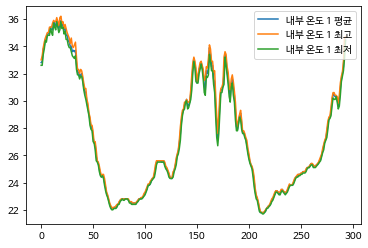

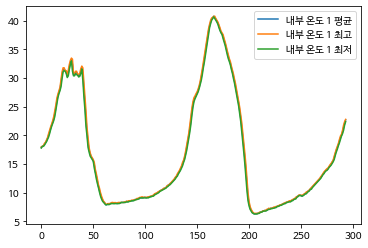

In [17]:
# 중기
a9.plot()
a7.plot()
a5.plot()

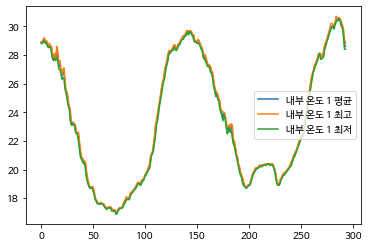

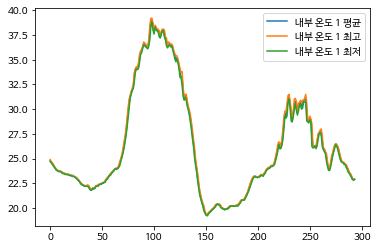

In [18]:
# 말기
a9_1.plot()
b4.plot()

온도 - 작물에 관계없이 초기, 중기, 말기 비슷한 분포를 보입니다.

[내부 습도와 초기/중기/말기의 분포]

In [19]:
csv_features = ['내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저']

b7 = pd.read_csv('/content/train/63805/63805.csv')[csv_features] #고추
b3 = pd.read_csv('/content/train/18978/18978.csv')[csv_features] #파프리카
b5 =  pd.read_csv('/content/train/18408/18408.csv')[csv_features] #시설포도

a9 =  pd.read_csv('/content/train/31161/31161.csv')[csv_features] #파프리카
a7 =  pd.read_csv('/content/train/53289/53289.csv')[csv_features] #고추
a5 =  pd.read_csv('/content/train/60102/60102.csv')[csv_features] #토마토

a9_1 =  pd.read_csv('/content/train/23323/23323.csv')[csv_features] #파프리카
b4 =  pd.read_csv('/content/train/54869/54869.csv')[csv_features] #시설포도

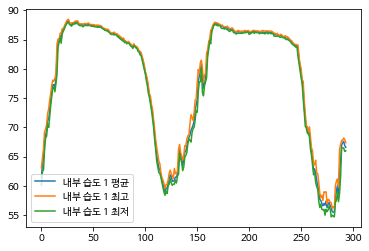

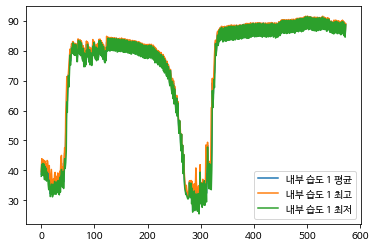

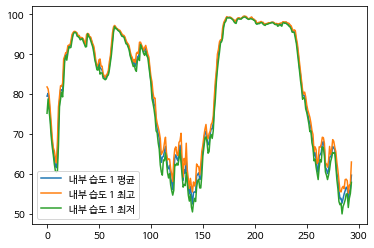

In [26]:
# 초기
b7.plot()
b3.plot()
b5.plot()

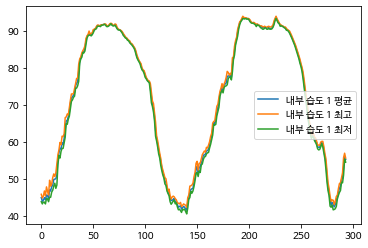

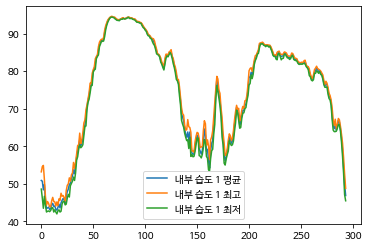

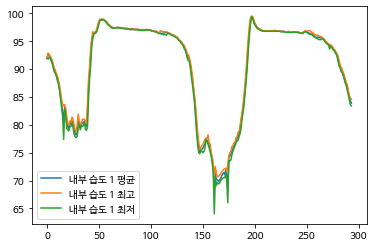

In [21]:
# 중기
a9.plot()
a7.plot()
a5.plot()

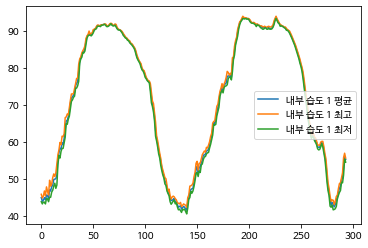

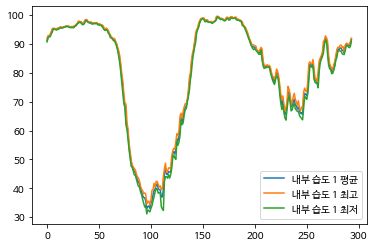

In [22]:
# 말기
a9_1.plot()
b4.plot()

습도 - 초기, 중기 비슷한 분포를 보이나 말기는 조금 다릅니다.

[내부 이슬점과 초기/중기/말기의 분포]

In [28]:
csv_features = ['내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

b7 = pd.read_csv('/content/train/63805/63805.csv')[csv_features] #고추
b3 = pd.read_csv('/content/train/18978/18978.csv')[csv_features] #파프리카
b5 =  pd.read_csv('/content/train/18408/18408.csv')[csv_features] #시설포도

a9 =  pd.read_csv('/content/train/31161/31161.csv')[csv_features] #파프리카
a7 =  pd.read_csv('/content/train/53289/53289.csv')[csv_features] #고추
a5 =  pd.read_csv('/content/train/60102/60102.csv')[csv_features] #토마토

a9_1 =  pd.read_csv('/content/train/23323/23323.csv')[csv_features] #파프리카
b4 =  pd.read_csv('/content/train/54869/54869.csv')[csv_features] #시설포도

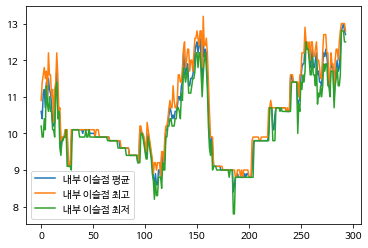

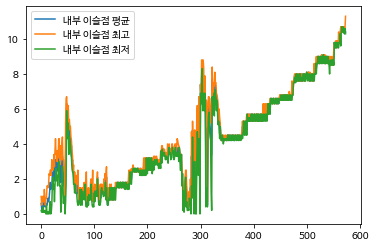

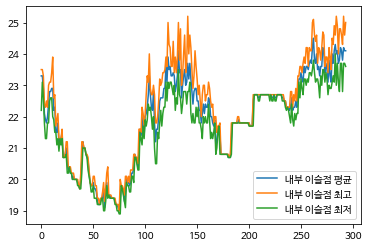

In [29]:
# 초기
b7.plot()
b3.plot()
b5.plot()

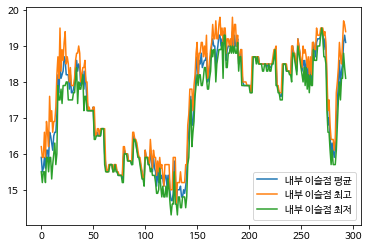

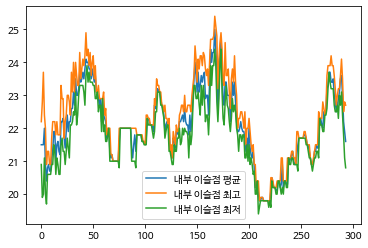

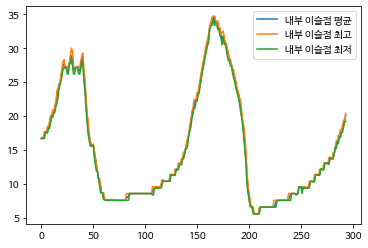

In [30]:
# 중기
a9.plot()
a7.plot()
a5.plot()

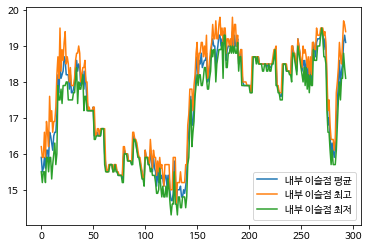

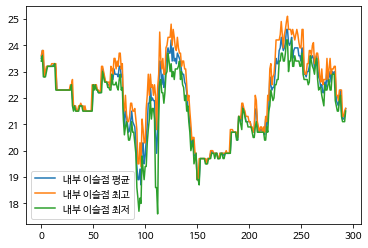

In [31]:
# 말기
a9_1.plot()
b4.plot()

이슬점 - 초기는 비슷한 분포를 보이나 중기와 말기는 조금 다름

### 2. 같은 질병을 가진 다른 작물들이 서로 어떤 분포를 보이는가?

1. 흰가루병  
- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [52]:
display(tr_json_df[tr_json_df["질병명"].str.contains('흰가루',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
3,"[{'x': 121.20540364583333, 'h': 302.6819506448...","[{'x': 234.5145244295635, 'h': 20.022972470238...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),초기(1),32522.jpg,20210622,1414,512,384,0,병해(1),3_a9_1,파프리카(3)_파프리카흰가루병(a9)_초기(1)
19,"[{'x': 0.0, 'h': 375.48694816468253, 'y': 91.8...","[{'x': 189.6039031498016, 'h': 16.900700644841...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),중기(2),32166.jpg,20210622,1525,512,242,0,병해(1),3_a9_2,파프리카(3)_파프리카흰가루병(a9)_중기(2)
21,"[{'x': 82.05714440724206, 'h': 113.14285714285...","[{'x': 175.08572048611111, 'h': 20.80000620039...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),44118.jpg,20211017,1253,512,384,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
25,"[{'x': 284.0369130291005, 'h': 160.91761739417...","[{'x': 327.9235284391534, 'h': 37.791253306878...",잎(3),토마토(2),토마토흰가루병(a5),생장기(12),중기(2),12185.jpg,20211017,1240,512,682,0,병해(1),2_a5_2,토마토(2)_토마토흰가루병(a5)_중기(2)
28,"[{'x': 56.186279296875, 'h': 238.7951388888888...","[{'x': 134.7275390625, 'h': 15.981987847222221...",잎(3),파프리카(3),파프리카흰가루병(a9),착화/과실기(13),중기(2),29854.jpg,20210629,1017,512,242,0,병해(1),3_a9_2,파프리카(3)_파프리카흰가루병(a9)_중기(2)


흰가루병 초기 데이터는 파프리카 데이터 밖에 없으므로 중기로 비교  
딸기흰가루병,오이 흰가루병,고추 흰가루병은 train data에 존재하지 않음

In [53]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저',
                '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', 
                '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'
                ]

f1 = pd.read_csv('/content/train/31161/31161.csv')[csv_features] # 파프리카 - 중기
f2 = pd.read_csv('/content/train/60102/60102.csv')[csv_features] # 토마토 - 중기

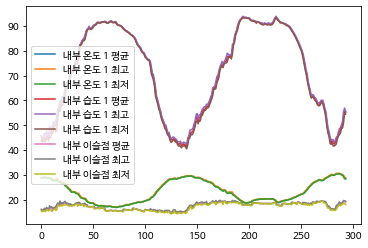

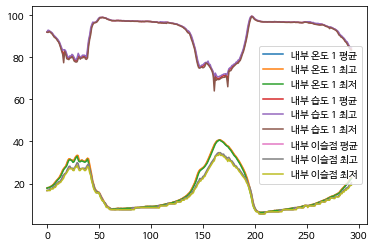

In [54]:
f1.plot()
f2.plot()

2. 탄저병
- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [51]:
display(tr_json_df[tr_json_df["질병명"].str.contains('탄저병',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
5,"[{'x': 69.8591812375992, 'h': 389.052362351190...","[{'x': 135.4280753968254, 'h': 27.428819444444...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),50788.jpg,20210902,1442,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)
8,"[{'x': 246.2476222826087, 'h': 402.28571428571...","[{'x': 307.1999870600414, 'h': 97.523809523809...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),58122.jpg,20210809,1707,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
31,"[{'x': 18.412302734375, 'h': 375.84509375, 'y'...","[{'x': 185.82659375, 'h': 70.31403125, 'y': 34...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),중기(2),64603.jpg,20210830,1520,512,384,0,병해(1),6_a11_2,시설포도(6)_시설포도탄저병(a11)_중기(2)
73,"[{'x': 291.04761904761904, 'h': 441.9047619047...","[{'x': 291.8095238095238, 'h': 167.61904761904...",열매(1),고추(5),고추탄저병(a7),착화/과실기(13),중기(2),46756.jpg,20210811,1735,512,682,0,병해(1),5_a7_2,고추(5)_고추탄저병(a7)_중기(2)
75,"[{'x': 40.17709495907738, 'h': 405.80974082341...","[{'x': 184.45709325396825, 'h': 68.57181609623...",열매(1),시설포도(6),시설포도탄저병(a11),과실성숙기(24),초기(1),50580.jpg,20210902,1742,512,384,0,병해(1),6_a11_1,시설포도(6)_시설포도탄저병(a11)_초기(1)


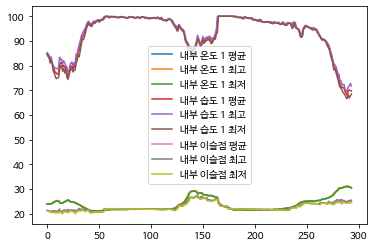

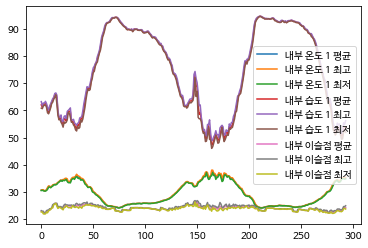

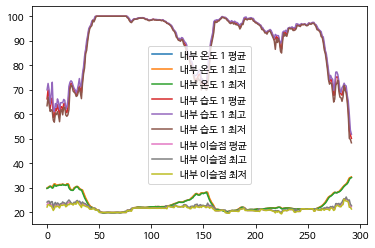

In [103]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

a11_1 = pd.read_csv('/content/train/50788/50788.csv')[csv_features] # 시설포도탄저병(a11) - 초기

a7 =  pd.read_csv('/content/train/12793/12793.csv')[csv_features] # 고추탄저병(a7) - 중기
a11_2 = pd.read_csv('/content/train/19548/19548.csv')[csv_features] # 시설포도탄저병(a11) - 중기

a11_1.plot()
a7.plot()
a11_2.plot()

3. 다량원소결핍(N)

- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [63]:
display(tr_json_df[tr_json_df["질병명"].str.contains('N',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
10,"[{'x': 89.57142857142857, 'h': 402.42860243055...","[{'x': 93.42857142857143, 'h': 393.42860243055...",잎(3),고추(5),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),51832.jpg,20211102,1138,512,384,0,생리장해(2),5_b6_1,고추(5)_다량원소결핍 (N)(b6)_초기(1)
30,"[{'x': 121.37329489087301, 'h': 338.1710999503...","[{'x': 130.5809306795635, 'h': 316.40764508928...",잎(3),고추(5),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),39886.jpg,20211102,1139,512,384,0,생리장해(2),5_b6_1,고추(5)_다량원소결핍 (N)(b6)_초기(1)
53,"[{'x': 113.1696041046627, 'h': 396.43303571428...","[{'x': 120.53575303819444, 'h': 382.3703497023...",잎(3),고추(5),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),61373.jpg,20211102,1137,512,384,0,생리장해(2),5_b6_1,고추(5)_다량원소결핍 (N)(b6)_초기(1)
55,"[{'x': 107.07365296378968, 'h': 333.9382750496...","[{'x': 110.14453900049604, 'h': 179.9236266121...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),12158.jpg,20211103,1537,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)
64,"[{'x': 126.96413070436508, 'h': 179.4670138888...","[{'x': 128.03557477678572, 'h': 136.0735212053...",잎(3),파프리카(3),다량원소결핍 (N)(b6),착화/과실기(13),초기(1),59362.jpg,20211029,1307,512,384,0,생리장해(2),3_b6_1,파프리카(3)_다량원소결핍 (N)(b6)_초기(1)


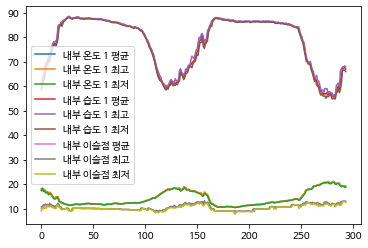

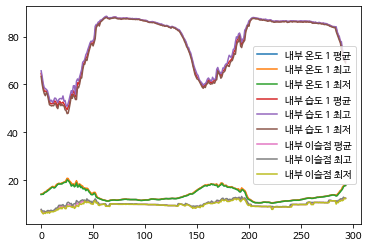

In [64]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

b6_5 =  pd.read_csv('/content/train/40640/40640.csv')[csv_features] # 고추 - 초기
b6_3 = pd.read_csv('/content/train/45375/45375.csv')[csv_features] # 파프리카 - 초기

b6_5.plot()
b6_3.plot()

4. 다량원소결핍(P)

- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [65]:
display(tr_json_df[tr_json_df["질병명"].str.contains('P',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
61,"[{'x': 122.54517764136905, 'h': 282.5905257936...","[{'x': 170.14482576884922, 'h': 96.00111607142...",잎(3),파프리카(3),다량원소결핍 (P)(b7),착화/과실기(13),초기(1),33794.jpg,20211126,0932,512,384,0,생리장해(2),3_b7_1,파프리카(3)_다량원소결핍 (P)(b7)_초기(1)
74,"[{'x': 139.88552517361111, 'h': 217.0293278769...","[{'x': 140.07248263888889, 'h': 216.3149026537...",잎(3),고추(5),다량원소결핍 (P)(b7),유모기(11),초기(1),36357.jpg,20211202,1300,512,384,0,생리장해(2),5_b7_1,고추(5)_다량원소결핍 (P)(b7)_초기(1)
83,"[{'x': 120.5350322420635, 'h': 225.94097222222...","[{'x': 122.20916263640873, 'h': 195.8747209821...",잎(3),고추(5),다량원소결핍 (P)(b7),유모기(11),초기(1),46914.jpg,20211202,1336,512,384,0,생리장해(2),5_b7_1,고추(5)_다량원소결핍 (P)(b7)_초기(1)
90,"[{'x': 143.97302827380952, 'h': 343.5322110615...","[{'x': 145.9824683779762, 'h': 340.18235367063...",잎(3),고추(5),다량원소결핍 (P)(b7),유모기(11),초기(1),43937.jpg,20211202,1358,512,384,0,생리장해(2),5_b7_1,고추(5)_다량원소결핍 (P)(b7)_초기(1)
108,"[{'x': 103.54255022321429, 'h': 272.9152405753...","[{'x': 147.77126736111111, 'h': 77.82885354662...",잎(3),파프리카(3),다량원소결핍 (P)(b7),착화/과실기(13),초기(1),55344.jpg,20211125,0918,512,384,0,생리장해(2),3_b7_1,파프리카(3)_다량원소결핍 (P)(b7)_초기(1)


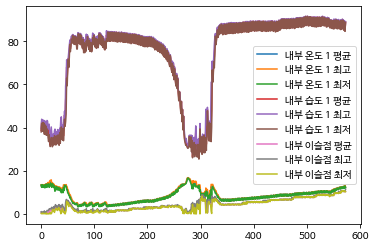

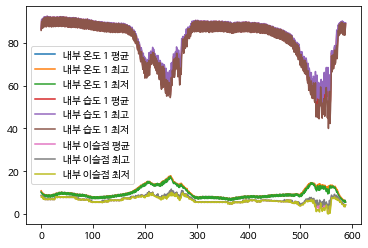

In [105]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

b7_5 =  pd.read_csv('/content/train/38058/38058.csv')[csv_features] # 고추 - 초기
b7_3 = pd.read_csv('/content/train/56139/56139.csv')[csv_features] # 파프리카 - 초기

b7_5.plot()
b7_3.plot()

5. 다량원소결핍(K)

- 식물이 달라도 같은 질병이면 같은 분포를 보인다.

In [67]:
display(tr_json_df[tr_json_df["질병명"].str.contains('K',na=False)].head())

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
6,"[{'x': 106.47309802827381, 'h': 370.9862971230...","[{'x': 110.49100167410714, 'h': 360.2718874007...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),20990.jpg,20211109,1205,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)
38,"[{'x': 94.35374038938492, 'h': 361.47606646825...","[{'x': 160.4056609623016, 'h': 36.653242807539...",잎(3),파프리카(3),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),43801.jpg,20211103,1802,512,384,0,생리장해(2),3_b8_1,파프리카(3)_다량원소결핍 (K)(b8)_초기(1)
51,"[{'x': 78.3477802579365, 'h': 370.986297123015...","[{'x': 84.3746357266865, 'h': 357.593284970238...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),48248.jpg,20211102,1147,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)
82,"[{'x': 107.1427486359127, 'h': 416.52250744047...","[{'x': 111.16064453125, 'h': 407.8170572916667...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),52332.jpg,20211109,1207,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)
85,"[{'x': 121.37188430059524, 'h': 366.6383928571...","[{'x': 124.72017609126983, 'h': 354.9193638392...",잎(3),고추(5),다량원소결핍 (K)(b8),착화/과실기(13),초기(1),65834.jpg,20211102,1604,512,384,0,생리장해(2),5_b8_1,고추(5)_다량원소결핍 (K)(b8)_초기(1)


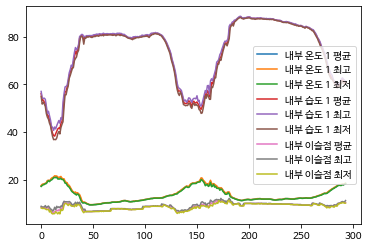

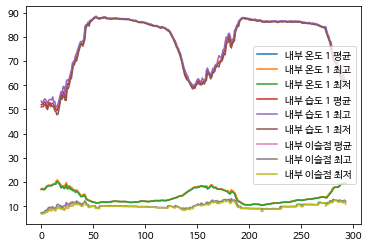

In [68]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

b8_5 =  pd.read_csv('/content/train/61914/61914.csv')[csv_features] # 고추 - 초기
b8_3 = pd.read_csv('/content/train/11242/11242.csv')[csv_features] # 파프리카 - 초기

b8_5.plot()
b8_3.plot()

### 3. 질병의 초기,중기,말기는 어떤 분포를 보이는가?

1) 칼슘결핍  
원인 : 토양건조가 오랫동안 지속

- 토마토 데이터 없음
- 파프리카 데이터 초기밖에 없음
- 파프리카 칼슘결핍 정상과 초기 비교

In [74]:
display(tr_json_df[tr_json_df["질병명"]=="칼슘결핍(b3)"].head())
display(tr_json_df[(tr_json_df["작물"]=="파프리카(3)") & (tr_json_df["피해정도"]=="정상(0)")])

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
24,"[{'x': 61.98335580977182, 'h': 377.6640625, 'y...","[{'x': 64.82032412574405, 'h': 124.82333519345...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),62718.jpg,20211101,1229,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
49,"[{'x': 71.3166000124008, 'h': 413.212394593254...","[{'x': 82.50069754464286, 'h': 159.64645337301...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),19305.jpg,20211101,1447,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
70,"[{'x': 83.70454334077381, 'h': 380.06987847222...","[{'x': 154.01812065972223, 'h': 228.3516865079...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),12949.jpg,20211103,1730,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
117,"[{'x': 59.14239211309524, 'h': 410.25006200396...","[{'x': 147.99124193948413, 'h': 125.8947792658...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),63805.jpg,20211102,1131,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)
169,"[{'x': 73.63116939484127, 'h': 343.77650669642...","[{'x': 200.89383370535714, 'h': 88.39419022817...",잎(3),파프리카(3),칼슘결핍(b3),착화/과실기(13),초기(1),11333.jpg,20211102,1129,512,384,0,생리장해(2),3_b3_1,파프리카(3)_칼슘결핍(b3)_초기(1)


,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
0,"[{'x': 74.32747395833333, 'h': 338.85001240079...",[],잎(3),파프리카(3),NaN,생장기(12),정상(0),24663.jpg,20210923,1346,512,384,0,정상(0),3_00_0,NaN
27,"[{'x': 102.52872333829364, 'h': 294.8395647321...",[],잎(3),파프리카(3),NaN,유모기(11),정상(0),57493.jpg,20210915,1618,512,384,0,정상(0),3_00_0,NaN
58,"[{'x': 82.49762059771825, 'h': 125.00454179067...",[],잎(3),파프리카(3),NaN,유모기(11),정상(0),17917.jpg,20210915,1613,512,242,0,정상(0),3_00_0,NaN
59,"[{'x': 133.92875, 'h': 510.75615625, 'y': 0.29...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),65744.jpg,20210915,1648,512,384,0,정상(0),3_00_0,NaN
78,"[{'x': 111.43818979414682, 'h': 184.3226531498...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),59509.jpg,20210915,1559,512,242,0,정상(0),3_00_0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5732,"[{'x': 55.45503937251984, 'h': 376.67578125, '...",[],잎(3),파프리카(3),NaN,생장기(12),정상(0),17836.jpg,20210924,1011,512,384,0,정상(0),3_00_0,NaN
5738,"[{'x': 93.37562779017857, 'h': 245.90435887896...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),38083.jpg,20210915,1602,512,242,0,정상(0),3_00_0,NaN
5745,"[{'x': 161.7860863095238, 'h': 356.79113963293...",[],줄기(5),파프리카(3),NaN,유모기(11),정상(0),26749.jpg,20210924,0903,512,384,0,정상(0),3_00_0,NaN
5748,"[{'x': 105.4278203125, 'h': 312.859875, 'y': 1...",[],잎(3),파프리카(3),NaN,유모기(11),정상(0),20205.jpg,20210915,1605,512,384,0,정상(0),3_00_0,NaN


In [75]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

f_b3_1 = pd.read_csv('/content/train/58687/58687.csv')[csv_features] #칼슘결핍 초기
f_b3_2 = pd.read_csv('/content/train/40019/40019.csv')[csv_features]
f_b3_3 =  pd.read_csv('/content/train/62587/62587.csv')[csv_features]

n_b3_1 = pd.read_csv('/content/train/21338/21338.csv')[csv_features] #칼슘결핍 정상
n_b3_2 = pd.read_csv('/content/train/27774/27774.csv')[csv_features]
n_b3_3 =  pd.read_csv('/content/train/25506/25506.csv')[csv_features]

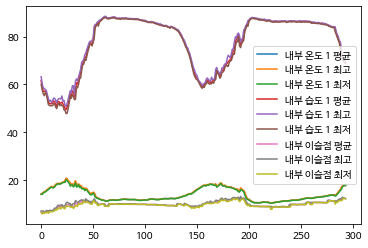

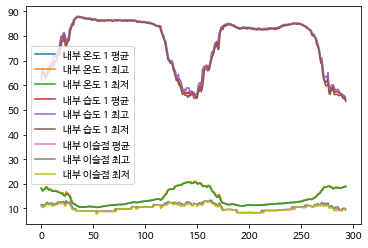

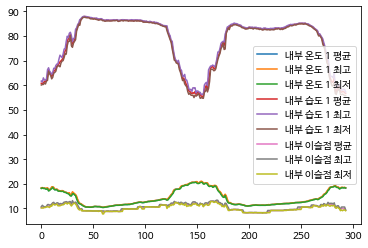

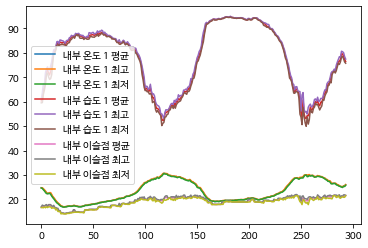

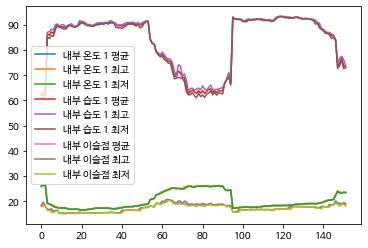

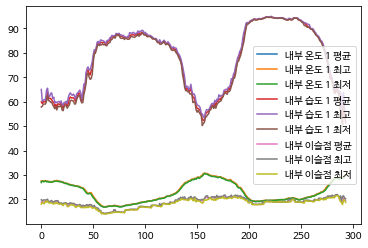

In [76]:
f_b3_1.plot()
f_b3_2.plot()
f_b3_3.plot()

n_b3_1.plot()
n_b3_2.plot()
n_b3_3.plot()

2) 일소피해(열매 햇빛 데임 증상)  
원인 : 고온 및 폭염  
- 초기랑 말기 데이터 밖에 없음

In [80]:
tr_json_df[tr_json_df["질병명"]=="일소피해(b4)"].head()

,주목객체,병해부위,촬영부위,작물,질병명,생육단계,피해정도,이미지id,촬영날짜,촬영시간,height,width,촬영지역,데이터종류,label_code,label_name
109,"[{'x': 25.445831783234127, 'h': 309.3819754464...","[{'x': 52.28571041046627, 'h': 54.428555927579...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),51146.jpg,20210825,1457,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
402,"[{'x': 94.72299895141559, 'h': 469.32112897588...","[{'x': 356.32608790632645, 'h': 124.2832051730...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),30889.jpg,20210807,0655,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
620,"[{'x': 135.79349440754982, 'h': 439.9823488290...","[{'x': 324.16967406501226, 'h': 154.7008694512...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),54869.jpg,20210807,0715,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)
671,"[{'x': 22.767950148809526, 'h': 362.2783668154...","[{'x': 216.6857173859127, 'h': 75.428571428571...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),초기(1),12232.jpg,20210825,1309,512,384,0,생리장해(2),6_b4_1,시설포도(6)_일소피해(b4)_초기(1)
839,"[{'x': 135.57368490038448, 'h': 460.6261796574...","[{'x': 319.82414365606434, 'h': 169.4756859489...",잎(3),시설포도(6),일소피해(b4),과실성숙기(24),말기(3),44592.jpg,20210807,1025,512,622,0,생리장해(2),6_b4_3,시설포도(6)_일소피해(b4)_말기(3)


In [81]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고','내부 온도 1 최저']

f1 = pd.read_csv('/content/train/12232/12232.csv')[csv_features] #초기
f2 = pd.read_csv('/content/train/51146/51146.csv')[csv_features]
f3 =  pd.read_csv('/content/train/30404/30404.csv')[csv_features]

l1 =  pd.read_csv('/content/train/59933/59933.csv')[csv_features] #말기
l2 =  pd.read_csv('/content/train/50378/50378.csv')[csv_features]
l3 =  pd.read_csv('/content/train/57335/57335.csv')[csv_features]

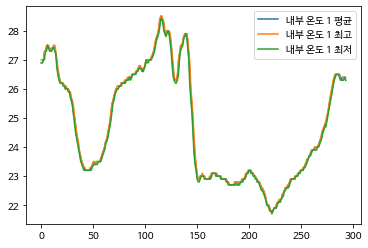

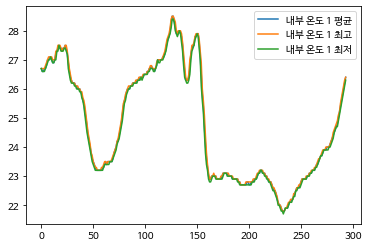

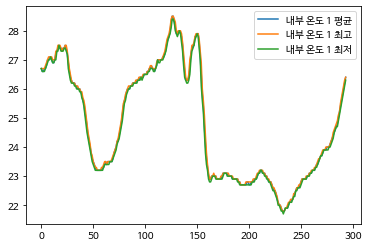

In [82]:
f1.plot()
f2.plot()
f3.plot()

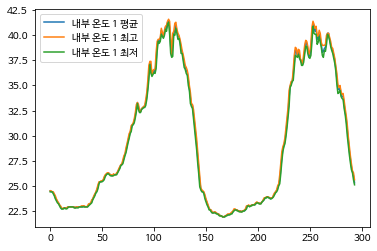

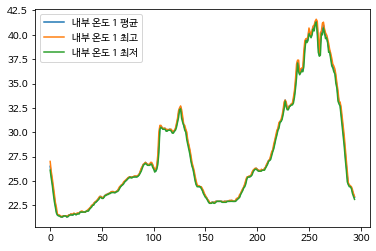

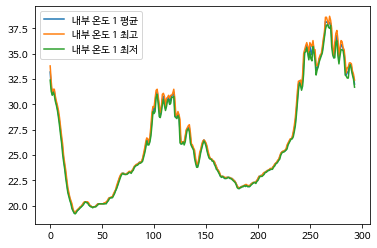

In [83]:
l1.plot()
l2.plot()
l3.plot()

초기보다 말기가 내부 온도가 대체로 높은 것을 볼 수 있다.

In [108]:
csv_features = ['내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저']

f1 = pd.read_csv('/content/train/12232/12232.csv')[csv_features] #초기
f2 = pd.read_csv('/content/train/51146/51146.csv')[csv_features]
f3 =  pd.read_csv('/content/train/30404/30404.csv')[csv_features]

l1 =  pd.read_csv('/content/train/59933/59933.csv')[csv_features] #말기
l2 =  pd.read_csv('/content/train/50378/50378.csv')[csv_features]
l3 =  pd.read_csv('/content/train/57335/57335.csv')[csv_features]

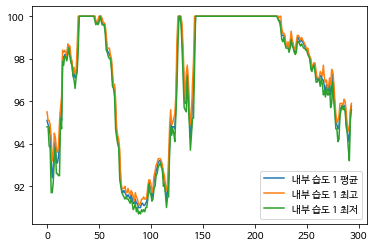

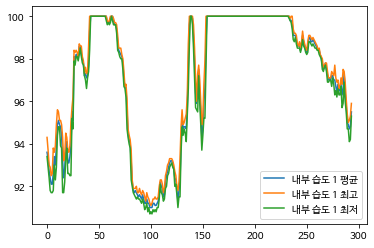

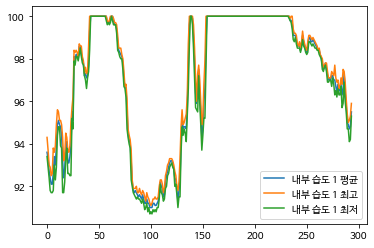

In [109]:
f1.plot()
f2.plot()
f3.plot()

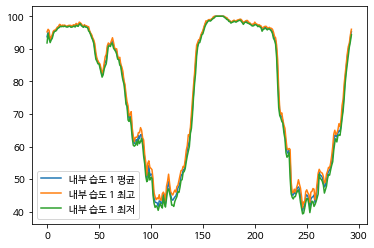

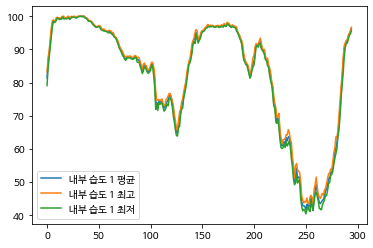

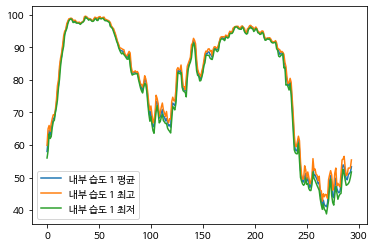

In [110]:
l1.plot()
l2.plot()
l3.plot()

In [111]:
csv_features = ['내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

f1 = pd.read_csv('/content/train/12232/12232.csv')[csv_features] #초기
f2 = pd.read_csv('/content/train/51146/51146.csv')[csv_features]
f3 =  pd.read_csv('/content/train/30404/30404.csv')[csv_features]

l1 =  pd.read_csv('/content/train/59933/59933.csv')[csv_features] #말기
l2 =  pd.read_csv('/content/train/50378/50378.csv')[csv_features]
l3 =  pd.read_csv('/content/train/57335/57335.csv')[csv_features]

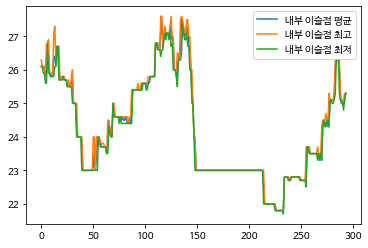

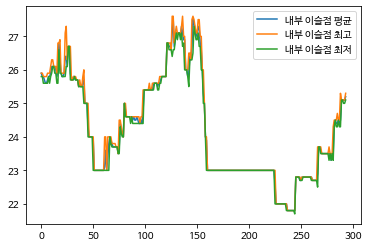

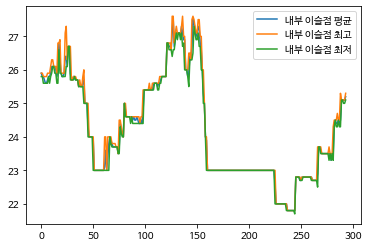

In [112]:
f1.plot()
f2.plot()
f3.plot()

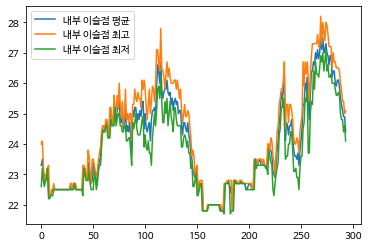

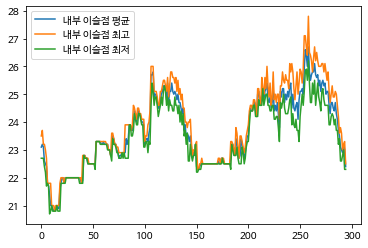

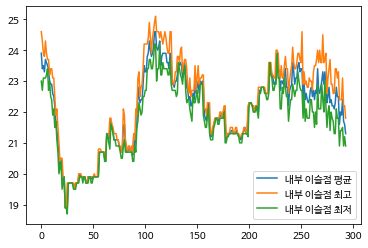

In [113]:
l1.plot()
l2.plot()
l3.plot()

습도와 이슬점은 초기와 말기에 별 차이 없다.